In [1]:
#df[df.ds > '2020-01-01'].sort_values(by='y',ascending=False).head(20)

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import s3fs
import boto3

from datetime import datetime, timedelta
from fbprophet import Prophet

%matplotlib inline

In [3]:
#plt.style.use('ggplot')

In [4]:
data = pd.read_csv('cellphonedata.csv')
data['ds'] = pd.to_datetime(data['ds'])

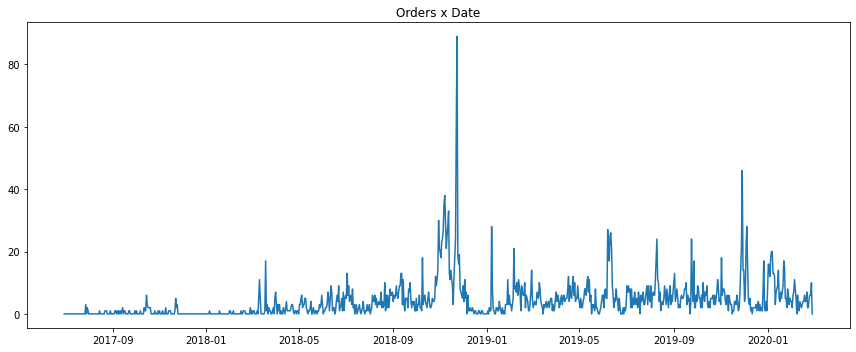

In [5]:
price_category = 'C'  #['A','B','C','D']

df = data[data['price_category']==price_category].copy().reset_index(drop=True)
df.drop(columns=['price_category','offer'],inplace=True)

plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'])
plt.title('Orders x Date')
plt.tight_layout()
plt.show()

In [6]:
df.head(2)

,ds,year,month,dayofweek,day,olist_price,freight_value,competition_price,stock,black_friday,carnival,christmas,friday,mothers_day,new_year,others,valentines,y
0,2017-06-30,2017,6,4,30,931.184286,25.73,931.184286,0.0,0,0,0,0,0,0,0,0,0.0
1,2017-07-01,2017,7,5,1,931.184286,25.73,931.184286,0.0,0,0,0,0,0,0,0,0,0.0


In [7]:
df.tail(2)

,ds,year,month,dayofweek,day,olist_price,freight_value,competition_price,stock,black_friday,carnival,christmas,friday,mothers_day,new_year,others,valentines,y
974,2020-02-27,2020,2,3,27,929.707727,22.893772,1007.34947,7454.0,0,0,0,0,0,0,0,0,10.0
975,2020-02-28,2020,2,4,28,936.661667,31.916422,1095.71750,127.0,0,0,0,0,0,0,0,0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 18 columns):
ds                   976 non-null datetime64[ns]
year                 976 non-null int64
month                976 non-null int64
dayofweek            976 non-null int64
day                  976 non-null int64
olist_price          976 non-null float64
freight_value        976 non-null float64
competition_price    976 non-null float64
stock                976 non-null float64
black_friday         976 non-null int64
carnival             976 non-null int64
christmas            976 non-null int64
friday               976 non-null int64
mothers_day          976 non-null int64
new_year             976 non-null int64
others               976 non-null int64
valentines           976 non-null int64
y                    976 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(12)
memory usage: 137.4 KB


In [9]:
# def lagged_variables(df, lags=10):
#     for lag in range(1,lags+1):
#         df['lag-'+str(lag)] = df['orders'].shift(lag)
#     return df.dropna(inplace=True)

# for df in [df_a, df_b, df_c, df_d]:
#     df = lagged_variables(df, lags=10)

# Preprocessing

### Train test split

In [10]:
# cut to include black friday in training set
split_point = round(df.shape[0] * 0.92)

train = df.iloc[:split_point].drop(columns=['ds'])
test  = df.iloc[split_point:].drop(columns=['ds'])

X_train, y_train = train.drop(columns=['y']).values, train['y'].values
X_test, y_test = test.drop(columns=['y']).values, test['y'].values

In [11]:
print("training set shape: ", train.shape)
print("    test set shape: ", test.shape)
print()
print("X_train shape: {}        y_train shape: {}".format(X_train.shape,y_train.shape))
print(" y_test shape: {}         y_test shape:  {}".format(X_test.shape,y_test.shape))

training set shape:  (898, 17)
    test set shape:  (78, 17)

X_train shape: (898, 16)        y_train shape: (898,)
 y_test shape: (78, 16)         y_test shape:  (78,)


### Scaling (optional)

In [12]:
from sklearn.preprocessing import StandardScaler

scaling_enabled = False

if scaling_enabled:
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)
    
    scaler = StandardScaler()
    y_train = scaler.fit_transform(y_train.reshape(-1,1))
    y_test  = scaler.transform(y_test.reshape(-1,1))

# Metrics: MAE and RMSE

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

scores = {}

## Baseline Models

#### y = 0

In [14]:
mae_train  = mean_absolute_error(y_train, np.zeros(y_train.shape))
rmse_train = np.sqrt(mean_squared_error(y_train, np.zeros(y_train.shape))) 

mae_test   = mean_absolute_error(y_test, np.zeros(y_test.shape))
rmse_test  = np.sqrt(mean_squared_error(y_test, np.zeros(y_test.shape)))

scores['baseline_zero'] = {'mae': (mae_train, mae_test), 
                           'rmse':(rmse_train, rmse_test)}

print(scores['baseline_zero'])

{'mae': (4.05456570155902, 6.141025641025641), 'rmse': (7.563318464241523, 7.878077339307007)}


#### y = mean(y_train)

In [15]:
# only use mean of y_train to avoid look-ahead bias
mean = np.mean(y_train)
train_pred = np.ones(y_train.shape)*mean
test_pred = np.ones(y_test.shape)*mean

mae_train  = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred)) 

mae_test   = mean_absolute_error(y_test, test_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_pred))

scores['baseline_mean'] = {'mae': (mae_train, mae_test), 
                           'rmse':(rmse_train, rmse_test)}

print(scores['baseline_mean'])

{'mae': (3.768644500771325, 3.652447033293359), 'rmse': (6.384691313076769, 5.357725424036513)}


#### y = y_previous_day

## Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# can't be negative
y_pred[y_pred < 0] = 0

mae_test   = mean_absolute_error(y_test, y_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

scores['LinearRegression'] = {'mae':mae_test, 
                              'rmse':rmse_test}

print(scores['LinearRegression'])

{'mae': 5.451252669043149, 'rmse': 6.198892319760036}


In [17]:
y_test.shape

(78,)

In [18]:
model.coef_.shape

(16,)

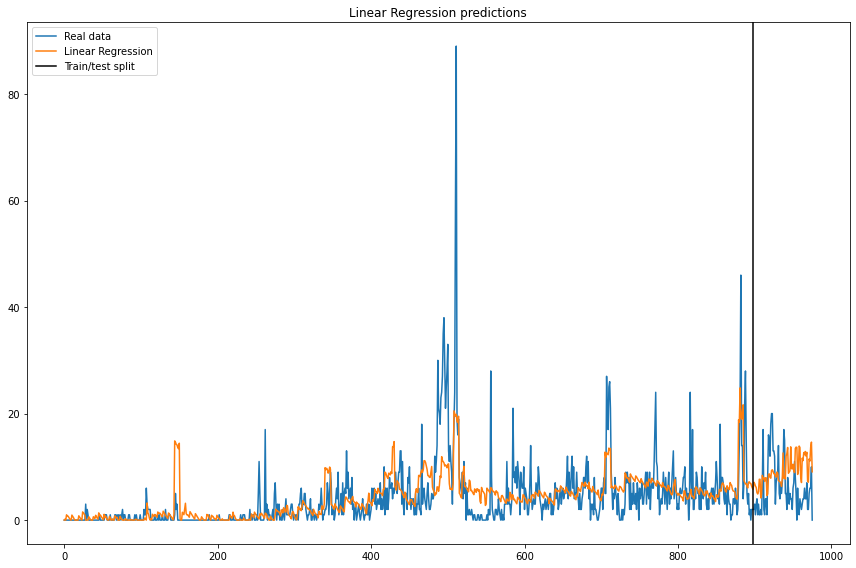

In [19]:
# Plotting

# recreate model (y = b + a*x) training data
lr = model.intercept_ + np.dot(X_train,model.coef_.T)
lr[lr < 0 ] = 0


fig, ax = plt.subplots(figsize=(12,8))

#ax.plot(df.y.values, label='True data')
ax.plot(np.append(y_train,y_test), label='Real data')
ax.plot(np.append(lr, y_pred), label='Linear Regression')
plt.axvline(x=split_point, color='black', label='Train/test split')
ax.set_title("Linear Regression predictions")

plt.legend()

plt.tight_layout()
plt.show()

## Decision Trees

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
model = DecisionTreeRegressor(max_depth = 10)
model = model.fit(X_train, y_train)

train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [22]:
mae_test   = mean_absolute_error(y_test, y_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

scores['DecisionTrees'] = {'mae': mae_test, 
                           'rmse':rmse_test}

print(scores['DecisionTrees'])

{'mae': 3.9646019719147247, 'rmse': 5.778575266510964}


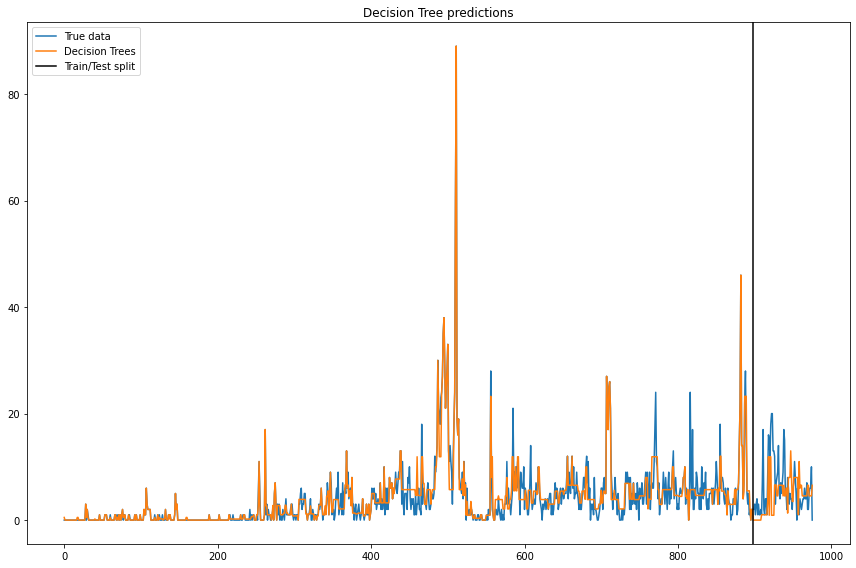

In [23]:
# Plotting
trees_predictions = np.append(train_pred, y_pred)

fig, ax = plt.subplots(figsize=(12,8))

## True values
#ax.plot(df.y.values, label='True data')
ax.plot(np.append(y_train,y_test), label='True data')
ax.plot(trees_predictions, label='Decision Trees')
plt.axvline(x=split_point, color='black', label='Train/Test split')
ax.set_title("Decision Tree predictions")

plt.legend()

plt.tight_layout()
plt.show()

## Random Forests

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
model = RandomForestRegressor(n_estimators=1000, max_depth=10)
model = model.fit(X_train, y_train)

train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

mae_test   = mean_absolute_error(y_test, y_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

scores['RandomForest'] = {'mae': mae_test, 
                           'rmse':rmse_test}

print(scores['RandomForest'])

{'mae': 4.188439891896989, 'rmse': 5.455215638039083}


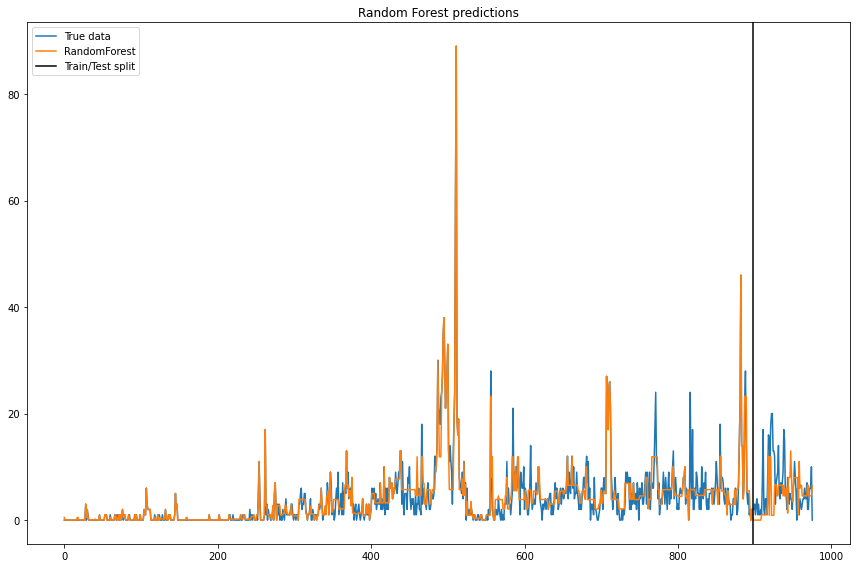

In [26]:
# Plotting
forest_predictions = np.append(train_pred, y_pred)

fig, ax = plt.subplots(figsize=(12,8))

## True values
#ax.plot(df.y.values, label='True data')
ax.plot(np.append(y_train,y_test), label='True data')
ax.plot(trees_predictions, label='RandomForest')
plt.axvline(x=split_point, color='black', label='Train/Test split')
ax.set_title("Random Forest predictions")

plt.legend()

plt.tight_layout()
plt.show()

## SVM

In [27]:
from sklearn.svm import SVR

In [28]:
model = SVR()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



In [29]:
mae_test   = mean_absolute_error(y_test, y_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

scores['SVR'] = {'mae': mae_test, 
                 'rmse':rmse_test}

print(scores['SVR'])

{'mae': 4.1819579332693495, 'rmse': 6.109939812219048}


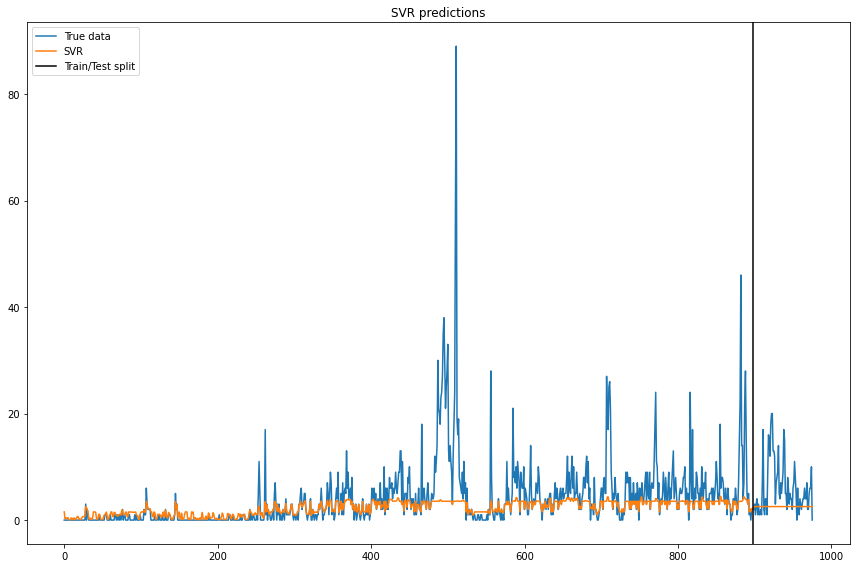

In [30]:
# Plotting
svr_predictions = np.append(train_pred, y_pred)

fig, ax = plt.subplots(figsize=(12,8))

## True values
#ax.plot(df.y.values, label='True data')
ax.plot(np.append(y_train,y_test), label='True data')
ax.plot(svr_predictions, label='SVR')
plt.axvline(x=split_point, color='black', label='Train/Test split')
ax.set_title("SVR predictions")

plt.legend()

plt.tight_layout()
plt.show()

## XGBoost

In [31]:
import xgboost as xgb

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test  = xgb.DMatrix(X_test, label=y_test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [215]:
model = xgb.XGBRegressor(colsample_bytree=0.3,
                 gamma=1.5,                 
                 learning_rate=0.001,
                 max_depth=6,
                 min_child_weight=1,  # 1
                 n_estimators=10000,                                                                    
                 reg_alpha=0.6, # 0.7
                 reg_lambda=0.9, # 0.9
                 subsample=0.7, # 0.7
                 seed=42,
                 epochs=100) #100

# 3.66 - 4.81

In [216]:
model = model.fit(X_train, y_train, eval_metric='rmse')

In [217]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
mae_test   = mean_absolute_error(y_test, test_predictions)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_predictions))

scores['XGBoost'] = {'mae': mae_test, 
                     'rmse':rmse_test}

print(scores['XGBoost'])

{'mae': 3.6697569611745005, 'rmse': 4.812192347164066}


In [225]:
# Hyperparameters
param = {
    'colsample_bytree':0.3,
    'gamma':1.5,                 
    'learning_rate':0.001,
    'max_depth':6,
    'min_child_weight':1,  # 1
#    'n_estimator':10000,                                                                    
    'reg_alpha':0.6, # 0.7
    'reg_lambda':0.9, # 0.9
    'subsample':0.7, # 0.7
#     'max_depth':5,
#     'eta':0.01,
#     'objective': 'reg:squarederror',
#     'eval_metric': ['mae', 'rmse'],
#     'lambda':1.2
}
epochs = 10000

model = xgb.train(param, xgb_train, epochs)
train_predictions = model.predict(xgb_train)
train_predictions[train_predictions < 0] = 0
test_predictions  = model.predict(xgb_test)
test_predictions[test_predictions < 0] = 0

mae_test   = mean_absolute_error(y_test, test_predictions)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_predictions))

scores['XGBoost'] = {'mae': mae_test, 
                     'rmse':rmse_test}

print(scores['XGBoost'])

{'mae': 3.684192027801122, 'rmse': 4.784147380481183}


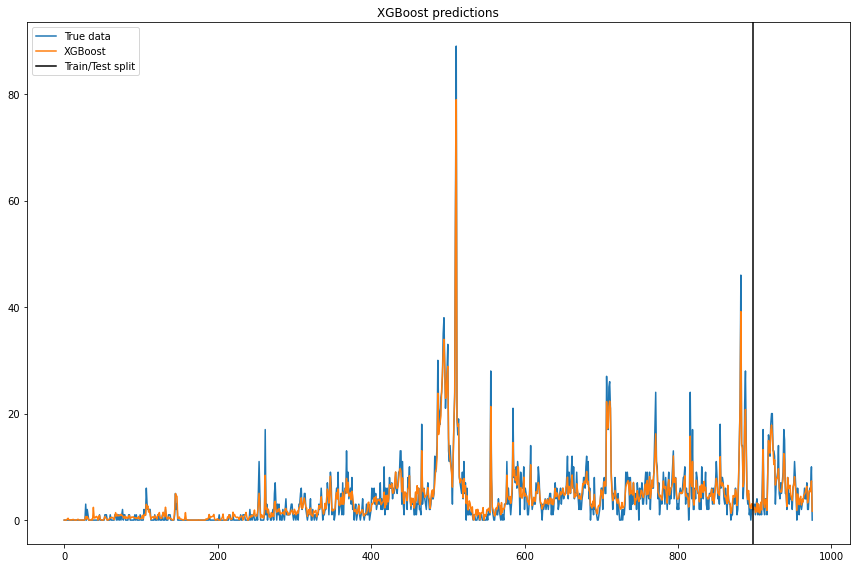

In [229]:
# Plotting
xgb_predictions = np.append(train_predictions, test_predictions)

fig, ax = plt.subplots(figsize=(12,8))

## True values
#ax.plot(df.y.values, label='True data')
ax.plot(np.append(y_train,y_test), label='True data')
ax.plot(xgb_predictions, label='XGBoost')
plt.axvline(x=split_point, color='black', label='Train/Test split')
ax.set_title("XGBoost predictions")

plt.legend()

plt.tight_layout()
plt.show()

## fbprophet

In [37]:
from fbprophet import Prophet

In [38]:
p_train = df[['ds','olist_price','freight_value','competition_price','y']].iloc[:split_point].copy().reset_index(drop=True)
p_test = df[['ds','olist_price','freight_value','competition_price','y']].iloc[split_point:].copy().reset_index(drop=True)

In [39]:
holidays = pd.read_csv('holidays.csv')

In [40]:
model = Prophet(holidays=holidays)
for column in p_train.columns:
    if column not in ['ds','y']:
        model.add_regressor(column)

In [41]:
model.fit(p_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
fcst = model.predict(p_test)
backtest = model.predict(p_train)

fcst[fcst.yhat < 0] = 0
backtest[backtest.yhat < 0] = 0

In [43]:
mae_test   = mean_absolute_error(y_test, fcst['yhat'])
rmse_test  = np.sqrt(mean_squared_error(y_test, fcst['yhat']))

scores['Prophet'] = {'mae': mae_test, 
                     'rmse':rmse_test}

print(scores['Prophet'])

{'mae': 4.738038146283767, 'rmse': 5.945001032781962}


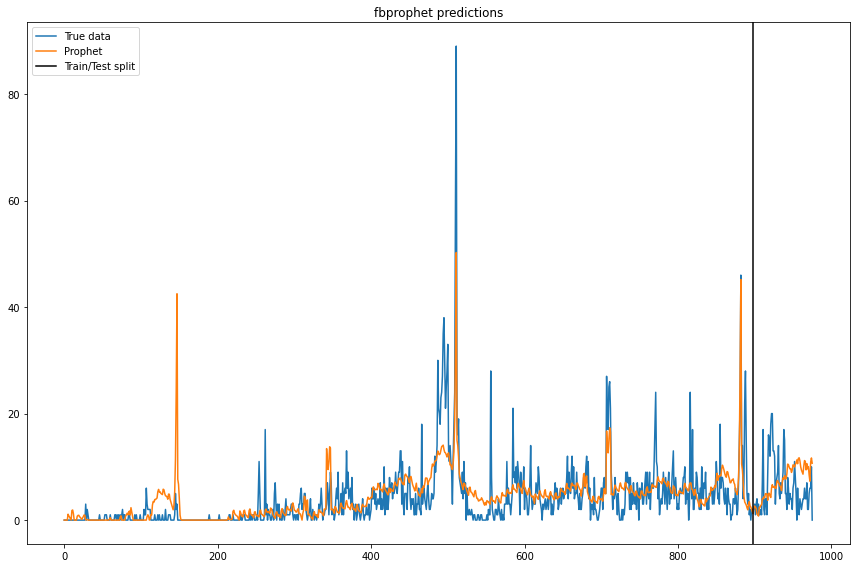

In [44]:
# Plotting
prophet_predictions = np.append(backtest['yhat'].values, fcst['yhat'].values)

fig, ax = plt.subplots(figsize=(12,8))

## True values
#ax.plot(df.y.values, label='True data')
ax.plot(np.append(y_train,y_test), label='True data')
ax.plot(prophet_predictions, label='Prophet')
plt.axvline(x=split_point, color='black', label='Train/Test split')
ax.set_title("fbprophet predictions")

plt.legend()

plt.tight_layout()
plt.show()

# Selected model

In [45]:
scores

{'baseline_zero': {'mae': (4.05456570155902, 6.141025641025641),
  'rmse': (7.563318464241523, 7.878077339307007)},
 'baseline_mean': {'mae': (3.768644500771325, 3.652447033293359),
  'rmse': (6.384691313076769, 5.357725424036513)},
 'LinearRegression': {'mae': 5.451252669043149, 'rmse': 6.198892319760036},
 'DecisionTrees': {'mae': 3.9646019719147247, 'rmse': 5.778575266510964},
 'RandomForest': {'mae': 4.188439891896989, 'rmse': 5.455215638039083},
 'SVR': {'mae': 4.1819579332693495, 'rmse': 6.109939812219048},
 'XGBoost': {'mae': 4.21281266441712, 'rmse': 5.2757034619953425},
 'Prophet': {'mae': 4.738038146283767, 'rmse': 5.945001032781962}}

In [ ]:
# Save to AWS

X = df.drop(columns=['ds','y']).values
y = df['y'].values

xgb_full = xgb.DMatrix(X, label=y)

# train model on whole dataset
model2save = xgb.train(param, xgb_full, epochs)

full_predictions = model2save.predict(xgb_full)
full_predictions[full_predictions < 0] = 0

# Save model to bucket
s3 = s3fs.S3FileSystem(anon=False, 
                       key='',
                       secret='')
# Use 'w' for py3, 'wb' for py2
with s3.open('bsa-correlation-one/models/xgboost_cellphones_{}.pkl'.format(price_category),'wb') as f:
    # END
    pickle.dump(model2save, f)

# XGBOOST GRID Search (TODO)

In [47]:
search_params = {
    'n_estimators':[100],
    'booster':['gbtree'], 
    'learning_rate':[0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3],
    'max_depth':[4,5,6,7,8,9,10],
    'sub_sample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'reg_lambda':[0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5],
    'seed':[42],
'eval_metric': ['mae', 'rmse']}

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
grid = GridSearchCV(xgb.XGBRegressor(), search_params)

In [50]:
#grid.fit(X_train, y_train)

In [51]:
import xgboost as xgb

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test  = xgb.DMatrix(X_test, label=y_test)




model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_lambda=0.8,
                 subsample=0.6,
                 seed=42,
                 epochs=100) 

model = model.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
mae_test   = mean_absolute_error(y_test, test_predictions)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_predictions))

scores['XGBoost'] = {'mae': mae_test, 
                     'rmse':rmse_test}

print(scores['XGBoost'])

{'mae': 4.241926395358184, 'rmse': 5.270777595457136}
